#텍스트 임베딩

컴퓨터에게 언어를 이해시키기 위해 문자를 숫자로 변형시켜야 한다.

1. One hot encoding

단어 집합(중복되지 않는 단어들의 집합)을 만들기

각 단어에 고유한 숫자를 부여하는 정수 encoding 예를 들어 단어 집합의 index로 단어들에게 숫자를 부여하는 것

이 숫자로 바뀐 단어들을 벡터로 변환: 차원이 단어 집합의 크기와 같고, 표현하고 싶은 단어의 index에 1을 부여하고 나머지 index에는 0을 부여하는 것.



In [ ]:
pip install konlpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 28.5 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
okt = Okt()
token = okt.morphs("나는 자연어 처리를 배운다")
print(token)

['나', '는', '자연어', '처리', '를', '배운다']


In [ ]:
word2index = {}
for voca in token:
  if voca not in word2index.keys():
    word2index[voca] = len(word2index)
print(word2index)

{'나': 0, '는': 1, '자연어': 2, '처리': 3, '를': 4, '배운다': 5}


In [ ]:
def one_hot_encoding(word, word2index):
  one_hot_vector = [0]*(len(word2index))
  index = word2index[word]
  one_hot_vector[index] = 1
  return one_hot_vector

one_hot_encoding('자연어', word2index)

[0, 0, 1, 0, 0, 0]

#one-hot-encoding의 한계

단어 집합의 개수가 커질 수록, 벡터를 다 저장하기 위해 필요한 공간이 계속 늘어난다는 것이다. 즉, 벡터의 차원이 계속 증가한다. Sparse problem을 가지게 된다.

단어 간의 유사도를 평가할 수 있는 방법이 사라진다.

호랑이, 고양이가 있을 때 각각 [0,1,0, ...], [0,0, ... 1]으로 표현된다고 가정하면 서로 관련성을 측정할 수 없게 된다.

In [ ]:
import torch

dof = torch.FloatTensor([1,0,0,0,0])
cat = torch.FloatTensor([0,1,0,0,0])
comp = torch.FloatTensor([0,0,1,0,0])
note = torch.FloatTensor([0,0,0,1,0])
book = torch.FloatTensor([0,0,0,0,1])

print(torch.cosine_similarity(dof, cat, dim=0))
print(torch.cosine_similarity(cat, comp, dim=0))
print(torch.cosine_similarity(comp, note, dim=0))
print(torch.cosine_similarity(note, book, dim=0))

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


#Word embedding: Sparse Represention이 아닌 Dense Representation

이 방법 또한 단어를 벡터로 표현하는 것을 의미한다. 다른 점은 벡터가 단어 집합의 크기로 설정되는 것이 아니라 사용자가 설정한 값으로 차원을 맞춘다. 또, 0과 1이 아닌 실수로 단어를 표현한다.

Pytorch의 nn.embedding(): 단어를 랜덤한 값을 가지는 밀집 벡터로 변환한 뒤에, 인공 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습한다

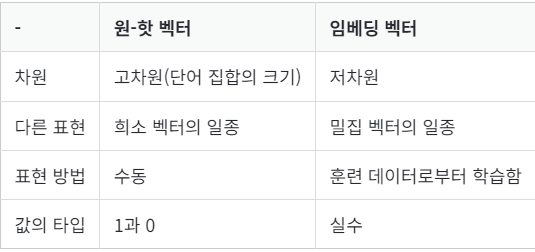

#단어 유사도 파악할 수 있게: Word2Vec

Word2Vec를 통해 단어 간 연산, 비교 등을 할 수 있게 되었다.

분산 표현: Distributed Representation

단어의 의미를 다차원 공간에 벡터화하는 방법을 찾게 되었다. 이는 분포 가설(distributional hypothesis)를 가정 하에 만들어진 표현 방법이다. '비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다'라는 가정을 따른다. (ex: 강아지와 귀엽다 예쁘다는 가까운 단어)

이 가설을 바탕으로 단어들을 학습하여 단어의 의미를 여러 차원에 분산하야 표현하는 것이다.



#Word2Vec의 첫번째 방식) CBOW

CBOW는 주변에 있는 단어들을 통해 중간에 있는 단어를 예측하는 방법이다.

"The fat cat sat on the mat"라는 문장이 있다면, {"The", "fat", "cat", "on", "the", "mat"}으로부터 "sat"을 예측하는 것이다. 이 예측 대상을 **center word**, 예측에 사용되는 단어들은 **context word**라고 한다. 단어를 예측하기 위해 앞, 뒤로 보는 단어들의 범위를 **window**라고 한다.
window가 2일 때, fat과 cat, on과 the를 보게 되는 것이다. 즉 window가 n일 때, 참고하는 context word 개수는 2n이다.

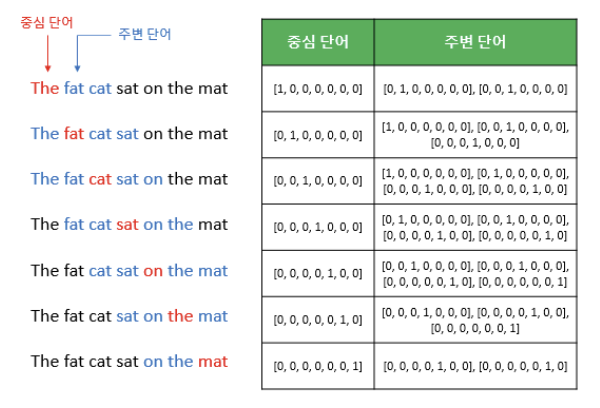

윈도우 크기가 정해졌다면, 윈도우를 sliding해서 주변 단어와 중심 단어 선택을 계속 바꾼다. 이런 과정으로 데이터 셋을 만들 수가 있다. 이때, Word2Vec에서 입력은 모두 one hot vector가 되어야 한다.

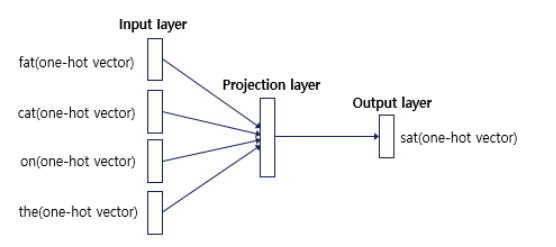

CBOW는 Shallow Neural Network으로 Activation function이 필요하지 않으며 룩업 테이블이라는 연산을 담당하는 층인 projection layer를 지니고 있다. 출력층에는 예측하고자 하는 단어의 one hot vector가 있어야 한다.

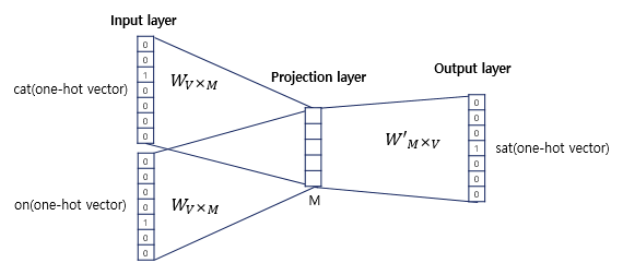

**주목해야 하는 것**

Projection Layer의 크기: M

가중치의 차원

입력층과 투사층 사이의 가중치 W는 VxM 행렬이며 투사층에서 출력층 사이의 사중치 W'는 MxV 행렬. 두 행렬은 관계 없음. 다른 행렬이다. CBOW는 주변 단어로 중심 단어를 더 정확히 맞추기 위해 W와 W'를 계속 학습해가는 구조이다.


#자세한 원리

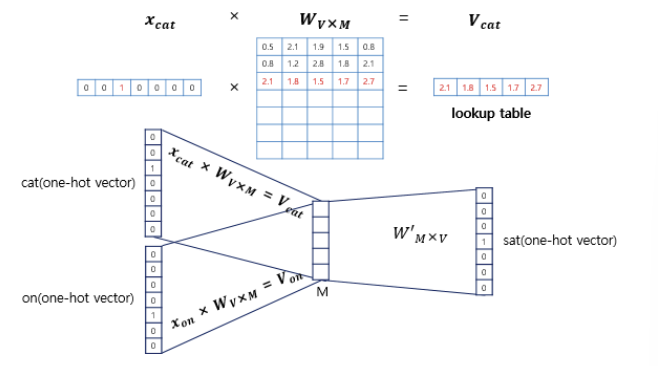

입력값은 1xV의 one hot vector이고 가중치는 VxM의 가중치이다. one hot vector가 index i에서 1을 가진다면 W와의 곱은 W의 i번째 행만 나오게 된다 (1xM). 따라서 이 작업을 lookup이라고 한다.

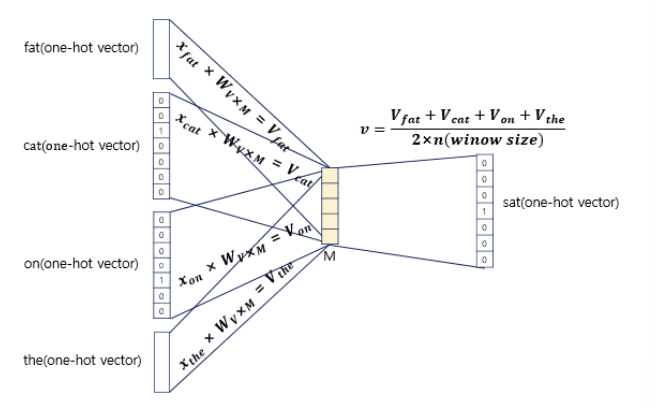

이렇게 가중치 W가 곱해서 생겨진 결과 벡터들은 투사층에서 하나의 평균 벡터로 변환이 된다. 이 평균 벡터는 가중치 W'와 곱해지게 되고 그 결과로 입력과 차원이 동일한 one hot vector가 딘다. 이 벡터는 마지막으로 softmax 함수를 통해 각 원소의 총 합이 1인 상태로 변하게 된다. 이 벡터를 **score vector**라고 한다. Score vector의 j번째 원소값은 j번째 단어가 중심 단어일 확률을 나타낸다. 이 원소값이 실제 중간 단어의 index에서 제일 높아야 한다.

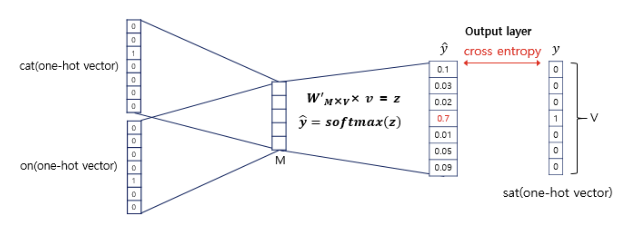

이 score vector를 y hat이라고 할 때 중심 단어를 y라고 했을 때, 오차를 줄이는 방법은 다음과 같다.

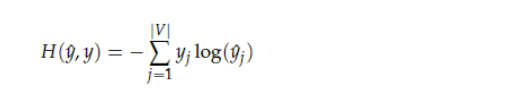

위 식을 y가 one hot vector라는 점을 이용하면 간소화시킬 수 있다. c를 중심 단어에서 1 을 가진 차원의 값의 index라고 한다면 y hat[c] = 1일 때는 정확하게 예측한 경우라고 봐야 한다. 이를 대입하면 -1 log(1) = 0이 된다.

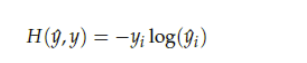


따라서,  값을 최소화하는 방향으로 학습해야 한다. W와 W'을 이제 back propagation을 통해 학습할 뒤, W의 어떤 행, W'의 어떤 열을 가지고 임베딩 벡터로 만들 지 결정하는 것이다. W와 W'의 평균치를 가지고 임베딩 벡터를 선택할 수도 있다.

#Word2Vec의 두번째 방식: Skip-gram

중심 단어로 주변 단어릉 예측하는 것이다.

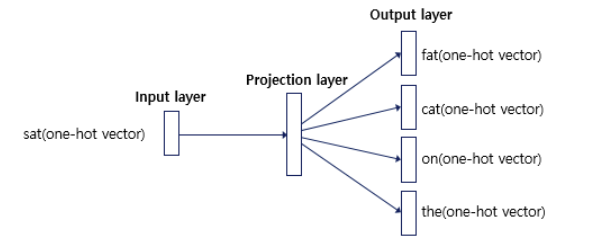



#Negative Sampling

Word2Vec에는 속도에 대한 문제점이 존재한다. softmax 함수를 통해 벡터 내의 모든 값을 0과 1의 사이의 값으로 변환하여 합이 모두 1이 되도록 하는 연산을 한다. 이를 이용하여 오차를 구하고 임베딩을 조정한다. 이 때, 중심 단어나 주변 단어가 아닌 벡터에 대해서도 모두 다 연산을 진행한다. 따라서, 단어 집합이 매우 클 때, 비효율적이다.

따라서, 필요한 단어 벡터에 대해서만 연산을 진행해야 단점을 개선할 수 있다. 중심 단어와 주변 단어가 포함된 소규모 단어 집합 (고양이, 강아지, 귀여움)과 관련이 없는 다른 소규모 단어 집합(컴퓨터, 회의실, 책)을 만들어 어떤 종류의 단어들에 집중해야 하는지 알아내는 것이다.

#네거티브 샘플링을 skip gram에 적용

기존의 skip-gram 모델

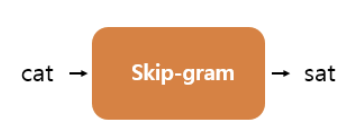

네거티브 샘플링이 적용된 skip-gram

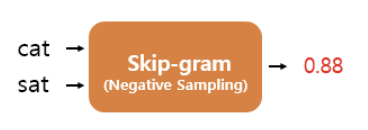

SGNS(Skip Gram with Negative Sampling)은 중심 단어와 주변 단어가 모두 입력이 되고 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측한다.

기존 skip-gram 데이터셋

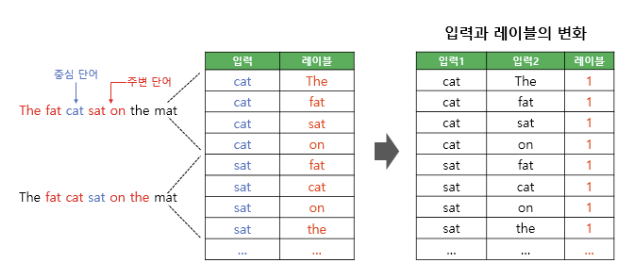

Negative Sampling이 적용된 skip-gram 데이터셋

skip-gram은 기본적으로 중심 단어를 입력, 주변 단어를 레이블로 한다. 하지만, SGNS은 중심 단어와 주변 단어를 각각 입력1, 입력2로 둔다. 이제 추가로 레이블이 0인 샘플들을 준비한다.

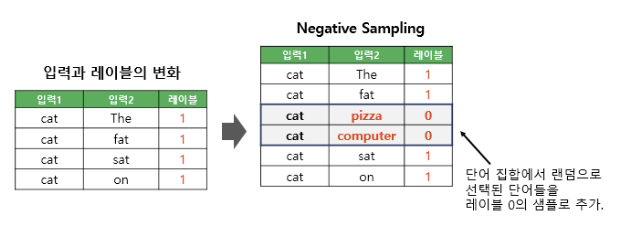

이제 두 개의 임베딩 테이블이 생성된다. 두 테이블의 크기는 동일하다.

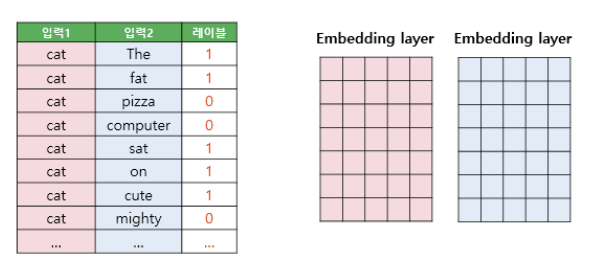

두 테이블 중 하나는 입력 1인 중심 단어의 테이블 룩업을 위한 임베딩 테이블, 다른 테이블은 입력 2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블이다. 각 단어는 각 임베딩 테이블을 룩업하여 임베딩 벡터로 변환된다.
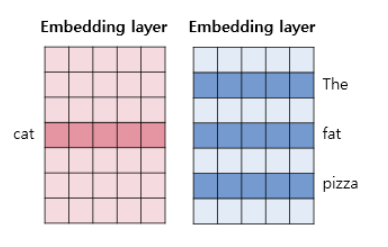

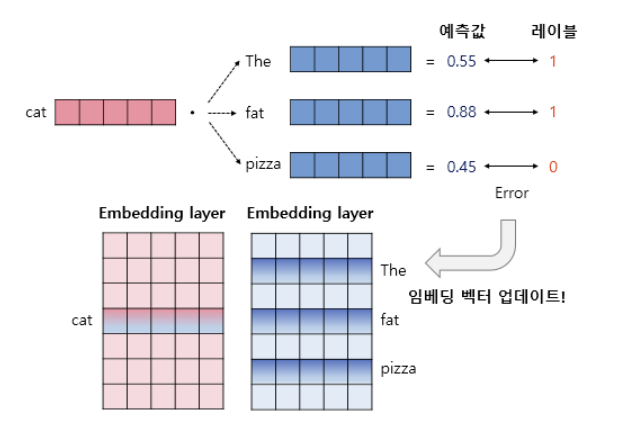

중심 단어와 주변 단어의 내적갑을 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파하여 중심 단어와 주변 단어의 임베딩 벡터값을 업데이트한다. 학습 후에는 두 embedding layer를 사용할 수도, 두 layer를 더할 수도, 연결할 수도 있다.